#Cryptoveeran: Machine Learning based Malicious URL Detector

In [0]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import os

In [0]:
#import kaggle's dataset --- URL  
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
urldata = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Cryptoveeran/dataset/urldata_raw.csv")

In [0]:
#Removing the unnamed columns as it is not necesary.
urldata = urldata.drop('Unnamed: 0',axis=1)
print(urldata.head())

print(urldata.tail(5))

#ITS DIMENSION
urldata.shape

                         url   label  result
0     https://www.google.com  benign       0
1    https://www.youtube.com  benign       0
2   https://www.facebook.com  benign       0
3      https://www.baidu.com  benign       0
4  https://www.wikipedia.org  benign       0
                                                      url      label  result
450155        http://ecct-it.com/docmmmnn/aptgd/index.php  malicious       1
450156  http://faboleena.com/js/infortis/jquery/plugin...  malicious       1
450157  http://faboleena.com/js/infortis/jquery/plugin...  malicious       1
450158                             http://atualizapj.com/  malicious       1
450159  http://writeassociate.com/test/Portal/inicio/I...  malicious       1


(450160, 3)

### 1.1 Length Features

In [0]:
!pip install tld
#Importing dependencies
from urllib.parse import urlparse
from tld import get_tld
import os.path

     |████████████████████████████████| 256kB 2.8MB/s 


In [0]:
#Length of URL
urldata['url_length'] = urldata['url'].apply(lambda i: len(str(i))) 

#Hostname Length
urldata['hostname_length'] = urldata['url'].apply(lambda i: len(urlparse(i).netloc))

#Path Length
urldata['path_length'] = urldata['url'].apply(lambda i: len(urlparse(i).path))

In [0]:
#First Directory Length   --- only  www.bmsce.ac.in
def fd_length(url):
    urlpath= urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

urldata['fd_length'] = urldata['url'].apply(lambda i: fd_length(i))

In [0]:
#Length of Top Level Domain  ----- .com .org .in .net .gov

urldata['tld'] = urldata['url'].apply(lambda i: get_tld(i,fail_silently=True))
def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1

urldata['tld_length'] = urldata['tld'].apply(lambda i: tld_length(i))

In [0]:
urldata = urldata.drop("tld",1)
urldata.head()

,url,label,result,url_length,hostname_length,path_length,fd_length,tld_length
0,https://www.google.com,benign,0,22,14,0,0,3
1,https://www.youtube.com,benign,0,23,15,0,0,3
2,https://www.facebook.com,benign,0,24,16,0,0,3
3,https://www.baidu.com,benign,0,21,13,0,0,3
4,https://www.wikipedia.org,benign,0,25,17,0,0,3


### 1.2 Count Features

In [0]:
urldata['count-'] = urldata['url'].apply(lambda i: i.count('-'))
urldata['count@'] = urldata['url'].apply(lambda i: i.count('@'))
urldata['count?'] = urldata['url'].apply(lambda i: i.count('?'))
urldata['count%'] = urldata['url'].apply(lambda i: i.count('%'))
urldata['count.'] = urldata['url'].apply(lambda i: i.count('.'))
urldata['count='] = urldata['url'].apply(lambda i: i.count('='))
urldata['count-http'] = urldata['url'].apply(lambda i : i.count('http'))
urldata['count-https'] = urldata['url'].apply(lambda i : i.count('https'))
urldata['count-www'] = urldata['url'].apply(lambda i: i.count('www'))

In [0]:
#COUNTING ------- digits, letter, and directory paths
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits
urldata['count-digits']= urldata['url'].apply(lambda i: digit_count(i))

In [0]:
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters
urldata['count-letters']= urldata['url'].apply(lambda i: letter_count(i))

In [0]:
def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')
urldata['count_dir'] = urldata['url'].apply(lambda i: no_of_dir(i))

In [0]:
urldata.head()

,url,label,result,tld_length,fd_length,count-,count@,count?,count%,count.,count=,count-http,count-https,count-www,count-digits,count-letters,count_dir,use_of_ip,short_url,url_length,hostname_length,path_length
0,https://www.google.com,benign,0,3,0,0,0,0,0,2,0,1,1,1,0,17,0,1,1,22,14,0
1,https://www.youtube.com,benign,0,3,0,0,0,0,0,2,0,1,1,1,0,18,0,1,1,23,15,0
2,https://www.facebook.com,benign,0,3,0,0,0,0,0,2,0,1,1,1,0,19,0,1,1,24,16,0
3,https://www.baidu.com,benign,0,3,0,0,0,0,0,2,0,1,1,1,0,16,0,1,1,21,13,0
4,https://www.wikipedia.org,benign,0,3,0,0,0,0,0,2,0,1,1,1,0,20,0,1,1,25,17,0


### 1.3 Binary Features

In [0]:
import re

In [0]:
#Use of IP or not in domain
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    if match:
        # print match.group()
        return -1
    else:
        # print 'No matching pattern found'
        return 1
urldata['use_of_ip'] = urldata['url'].apply(lambda i: having_ip_address(i))

In [0]:
def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return -1
    else:
        return 1
urldata['short_url'] = urldata['url'].apply(lambda i: shortening_service(i))

In [0]:
urldata.head()


,url,label,result,tld_length,fd_length,count-,count@,count?,count%,count.,count=,count-http,count-https,count-www,count-digits,count-letters,count_dir,use_of_ip,short_url,url_length,hostname_length,path_length
0,https://www.google.com,benign,0,3,0,0,0,0,0,2,0,1,1,1,0,17,0,1,1,22,14,0
1,https://www.youtube.com,benign,0,3,0,0,0,0,0,2,0,1,1,1,0,18,0,1,1,23,15,0
2,https://www.facebook.com,benign,0,3,0,0,0,0,0,2,0,1,1,1,0,19,0,1,1,24,16,0
3,https://www.baidu.com,benign,0,3,0,0,0,0,0,2,0,1,1,1,0,16,0,1,1,21,13,0
4,https://www.wikipedia.org,benign,0,3,0,0,0,0,0,2,0,1,1,1,0,20,0,1,1,25,17,0


# 2. Data Visualization

104438 345722


Text(0, 0.5, 'Number Of URLs')

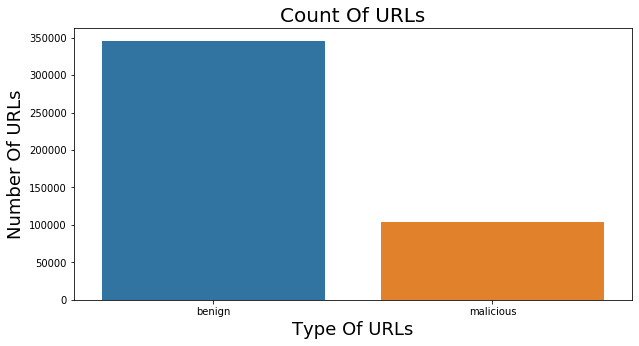

In [0]:
plt.figure(figsize=(10,5))
sns.countplot(x='label',data=urldata)
cnz,cno=0,0;
for i in list(urldata['result']):
  if(i==0):
    cnz+=1
  else: cno+=1
print(cno,cnz)
plt.title("Count Of URLs",fontsize=20)
plt.xlabel("Type Of URLs",fontsize=18)
plt.ylabel("Number Of URLs",fontsize=18)

Text(0, 0.5, 'Number Of URLs')

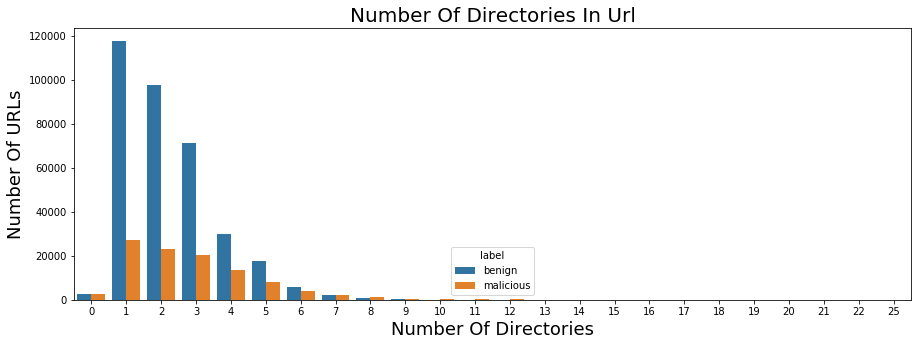

In [0]:
plt.figure(figsize=(15,5))
plt.title("Number Of Directories In Url",fontsize=20)
sns.countplot(x='count_dir',data=urldata,hue='label')
plt.xlabel("Number Of Directories",fontsize=18)
plt.ylabel("Number Of URLs",fontsize=18)

## 3. Building Models Using Lexical Features Only

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as mat

#for prediction
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer

In [0]:
#Predictor Variables
x = urldata[['hostname_length','path_length', 'fd_length', 'tld_length', 'count-', 'count@', 'count?','count%', 'count.', 'count=', 'count-http','count-https', 'count-www', 'count-digits','count-letters', 'count_dir', 'use_of_ip']]

#Target Variable
y = urldata['result']

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.3, random_state=42)




In [0]:
print("Dimension of Url Data: ",x.shape,y.shape)

print("TRAINING")
print(x_train.shape)

print("TESTING")
print(x_test.shape)

Dimension of Url Data:  (450160, 17) (450160,)
TRAINING
(135048, 17)
TESTING
(315112, 17)


In [0]:
#Splitting the data into Training and Testing
#

# **COMPARISON OF Decision Tree, Random Forest and Logistic Regression**

**TRAINING**

In [0]:
#Decision Tree
dt_model = DecisionTreeClassifier()
dt_model.fit(x_train,y_train)
dt_predictions = dt_model.predict(x_test)
decAcc=round(accuracy_score(y_test,dt_predictions)*100,5)

#----------------------------------------------------
#Random Forest
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
rfc_predictions = rfc.predict(x_test)
randAcc=round(accuracy_score(y_test, rfc_predictions)*100,5)

#-----------------------------------------------------
#Logistic Regression
log_model = LogisticRegression()
log_model.fit(x_train,y_train)
log_predictions = log_model.predict(x_test)
logiAcc=round(accuracy_score(y_test,log_predictions)*100,5)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [0]:
print("Decision Tree",confusion_matrix(y_test,dt_predictions))
print("Random Forest",confusion_matrix(y_test,rfc_predictions))
print("Logistic Regression",confusion_matrix(y_test,log_predictions))

Decision Tree [[241356    593]
 [   708  72455]]
Random Forest [[241665    284]
 [   639  72524]]
Logistic Regression [[241440    509]
 [   635  72528]]


**TESTING**

In [0]:


dt_model = DecisionTreeClassifier()
dt_model.fit(x_test,y_test)
dt_predictions = dt_model.predict(x_test)
decAcc1=round(accuracy_score(y_test,dt_predictions)*100,5)


#----------------------------------------------------
#Random Forest
rfc = RandomForestClassifier()
rfc.fit(x_test, y_test)
rfc_predictions = rfc.predict(x_test)
randAcc1=round(accuracy_score(y_test, rfc_predictions)*100,5)

#-----------------------------------------------------
#Logistic Regression
log_model = LogisticRegression()
log_model.fit(x_test,y_test)
log_predictions = log_model.predict(x_test)
logiAcc1=round(accuracy_score(y_test,log_predictions)*100,5)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[99.58713, 99.70709, 99.63695] 



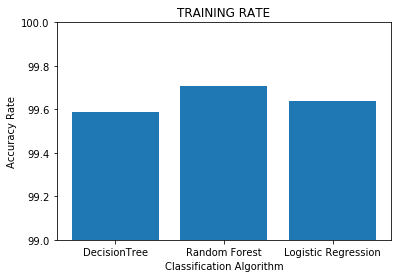

Random Forest 99.70709 %




[99.93748, 99.90829, 99.63918]


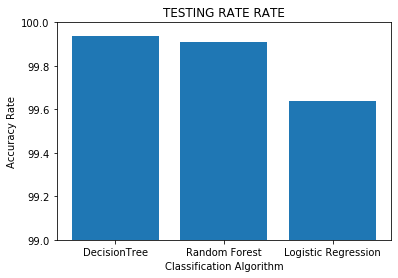

DecisionTree 99.93748 %


In [0]:
accuracy=[decAcc,randAcc,logiAcc]
print(accuracy,"\n")
accLabels=['DecisionTree','Random Forest','Logistic Regression']
mat.bar(accLabels,accuracy)
mat.xlabel('Classification Algorithm')
mat.ylabel('Accuracy Rate')
mat.title("TRAINING RATE")
mat.ylim(bottom=int(min(accuracy)),top=100)
mat.show()

#BEST PERFORMER
print(accLabels[accuracy.index(max(accuracy))],max(accuracy),"%")
print("\n\n\n")

#TESTING ACCURACY -0---------------------------

acc=['DecisionTree','Random Forest','Logistic Regression']
accRt=[decAcc1,randAcc1,logiAcc1]
print(accRt)
mat.bar(acc,accRt)
mat.xlabel('Classification Algorithm')
mat.ylabel('Accuracy Rate')
mat.title("TESTING RATE RATE")
mat.ylim(bottom=int(min(accRt)),top=100)
mat.show()

#BEST PERFORMER
print(acc[accRt.index(max(accRt))],max(accRt),"%")


In [0]:
#PREDICTING FROM USER INPUT
"""print("Enter URL")
isMalicious=input()

try:
  verdict=list(urldata[urldata['url'].str.contains(i)]['label'].head(1))
  print("-----------------------\nFINAL PREDICTION\nThe Webiste is",len(verdict),"\n------------------------")
except:
  print("N/A")

print("\nPercent Of Malicious URLs:{:.2f} %".format(len(urldata[urldata['label']=='malicious'])/len(urldata['label'])*100))
print("Percent Of Benign URLs:{:.2f} %".format(len(urldata[urldata['label']=='benign'])/len(urldata['label'])*100))"""

'print("Enter URL")\nisMalicious=input()\n\ntry:\n  verdict=list(urldata[urldata[\'url\'].str.contains(i)][\'label\'].head(1))\n  print("-----------------------\nFINAL PREDICTION\nThe Webiste is",len(verdict),"\n------------------------")\nexcept:\n  print("N/A")\n\nprint("\nPercent Of Malicious URLs:{:.2f} %".format(len(urldata[urldata[\'label\']==\'malicious\'])/len(urldata[\'label\'])*100))\nprint("Percent Of Benign URLs:{:.2f} %".format(len(urldata[urldata[\'label\']==\'benign\'])/len(urldata[\'label\'])*100))'